In [1]:
import pandas as pd
import harboropt_lp_valueadditionalenergy_retirement
from ortools.linear_solver import pywraplp
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tnrange
import seaborn as sns
%reload_ext autoreload
%autoreload 2

In [2]:
today_date = '1_13_22'

#### In the cell below, you can change the following input parameters:


initial_state_of_charge = state of charge of all storage resources at first time step

timespan = lifespan of portfolio in years (future variable costs are discounted based on this value)

gas_fuel_cost = cost of fuel for natural gas plants ($/mmbtu)

discount_rate = annual rate of decay of the value of money

build_years = number of years over which portfolio of resources is built

transmission_cost_per_mw = cost of transmission capacity for out of basin resources ($/MW)

storage_resilience_incentive_per_kwh = incentive per kwh of resilient storage capacity ($/kwh)

resilient_storage_grid_fraction = fraction of resilient storage capacity that can be used by grid (vs. reserved for host)

carbon_cost_per_ton = cost of emitting one metric ton of CO2 ($/tonne)

pm25_cost_per_ton = cost of emitting one metric ton of PM2.5 ($/tonne)

nox_cost_per_ton_LA = cost of emitting one metric ton of NOx in LA ($/tonne) 

so2_cost_per_ton_LA = cost of emitting one metric ton of SO2 in LA ($/tonne)

pm10_cost_per_ton = cost of emitting one metric ton of PM10 ($/tonne)


#### After running the cells below, wait for this message before running any subsequent cells: 'Solver found optimal solution.'


In [3]:
####Set up Harbor demand profile.
demand_hour_start = 0
demand_length_hours = 8760
demand = pd.read_csv('data/harbor_hourly_gen_emissions_2019.csv')
demand = demand.fillna(0)
demand = demand[demand_hour_start:demand_hour_start+demand_length_hours]

In [4]:
####Set up marginal health damage rates.
ladwp_marginal_healthdamages = pd.read_csv('data/WattTime_MOER/LDWP_healthdamage_moer.csv')
index_list = ladwp_marginal_healthdamages[ladwp_marginal_healthdamages['healthdamage_moer'].isna()].index.tolist()
for index in index_list:
    previous_index = index-1
    ladwp_marginal_healthdamages.loc[index, 'healthdamage_moer']= ladwp_marginal_healthdamages.loc[previous_index, 'healthdamage_moer']

if (ladwp_marginal_healthdamages['healthdamage_moer'].isna()).sum()>0:
    print('Nan values in LADWP marginal healthdamages file.')

In [5]:
#Set up marginal CO2 emission rates.
ladwp_marginal_co2 = pd.read_csv('data/WattTime_MOER/LDWP_MOERv3_CO2_2019.csv')
ladwp_marginal_co2['date'] = pd.to_datetime(ladwp_marginal_co2['timestamp_utc']).dt.date
ladwp_marginal_co2['hour'] = pd.to_datetime(ladwp_marginal_co2['timestamp_utc']).dt.hour
ladwp_marginal_co2 = ladwp_marginal_co2.groupby(['date','hour']).mean(['moer (lbs CO2/MWh)']).reset_index()

In [6]:
#Loops through different retirement years, running LP for each retirement year and storing results.

retirement_year_runs = {}

for retirement_year in np.arange(2021, 2022, 1):
    print(retirement_year)
    lp = harboropt_lp_valueadditionalenergy_retirement.LinearProgram(solver_type = 'GLOP', demand_profile = demand, 
                marginal_healthdamages = ladwp_marginal_healthdamages, marginal_co2 = ladwp_marginal_co2, build_start_year = 2020, harbor_retirement_year = retirement_year,
                storage_can_charge_from_grid = False, ee_cost_type = 'utility_side')
    lp.solve()
    retirement_year_runs[retirement_year] = lp 

2021
     state              facility_name  facility_id  year      date  hour  \
0       CA  Harbor Generating Station          399  2019    1/1/19     0   
1       CA  Harbor Generating Station          399  2019    1/1/19     1   
2       CA  Harbor Generating Station          399  2019    1/1/19     2   
3       CA  Harbor Generating Station          399  2019    1/1/19     3   
4       CA  Harbor Generating Station          399  2019    1/1/19     4   
...    ...                        ...          ...   ...       ...   ...   
8755    CA  Harbor Generating Station          399  2019  12/31/19    19   
8756    CA  Harbor Generating Station          399  2019  12/31/19    20   
8757    CA  Harbor Generating Station          399  2019  12/31/19    21   
8758    CA  Harbor Generating Station          399  2019  12/31/19    22   
8759    CA  Harbor Generating Station          399  2019  12/31/19    23   

      load_mw  so2_lb  nox_lb  co2_short_tons  heat_input_mmbtu  
0         0.0   

#### Save model iteration results to folder.

In [7]:
input_param_list = [
    'solver_type',
    'selected_resource', 
    'initial_state_of_charge', 
    'storage_lifespan', 
    'portfolio_timespan',
    'storage_can_charge_from_grid', 
    'wholesale_cost_electricity_mwh',
    'discount_rate', 
    'cost', 
    'health_cost_range',
    'cost_projections',
    'build_start_year', 
    'harbor_retirement_year',
    'ee_cost_type', 
    'transmission_capex_cost_per_mw',
    'transmission_annual_cost_per_mw', 
    'storage_resilience_incentive_per_kwh', 
    'resilient_storage_grid_fraction', 
    'social_cost_carbon_short_ton', 
    'avoided_marginal_generation_cost_per_mwh', 
    'diesel_genset_carbon_per_mw',
    'diesel_genset_pm25_per_mw', 
    'diesel_genset_nox_per_mw', 
    'diesel_genset_so2_per_mw', 
    'diesel_genset_pm10_per_mw', 
    'diesel_genset_fixed_cost_per_mw_year', 
    'diesel_genset_mmbtu_per_mwh', 
    'diesel_genset_cost_per_mmbtu', 
    'diesel_genset_run_hours_per_year',
]


In [8]:
input_df_list = [
    'demand_profile',
    'marginal_co2',
    'marginal_healthdamages'
]

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [9]:
#Choose lp runs dictionary to store results for.
runs_dict = retirement_year_runs

for key in runs_dict.keys():
    lp = runs_dict[key]
    results_dict = lp.__dict__
    
    solver_type = results_dict['solver_type']
    harbor_retirement_year = results_dict['harbor_retirement_year'].astype(str)
    if lp.solve() == 0:
        solution_result = 'OPTIMAL'
    if lp.solve() == 1:
        solution_result = 'FEASIBLE'
    if lp.solve() == 2:
        solution_result = 'INFEASIBLE'
    if lp.solve() == 3:
        solution_result = 'UNBOUNDED'
    if lp.solve() == 4:
        solution_result = 'ABNORMAL'
        
    folder_name = solver_type + 'valueAdditional0'+'_retirement'+ harbor_retirement_year + solution_result +'_' + today_date + str(np.random.rand(1,1).item())
    path = os.path.join('model_run_results', folder_name)
    os.mkdir(path)
    
    model_inputs_df = pd.DataFrame({'input':input_param_list})
    
    for input_name in input_param_list:
        input_value = results_dict[input_name]
        input_name_inds = model_inputs_df['input']==input_name
        model_inputs_df.loc[input_name_inds,'value']=input_value
    model_inputs_df.to_csv(path+'/input_parameter_values.csv')
    
    for input_df in input_df_list:
        df = results_dict[input_df]
        df.to_csv(path+'/'+input_df+'.csv')
        

Solver found optimal solution.
Problem solved in 3343597.000000 milliseconds
Problem solved in 0 iterations
Number of variables = 438236
Number of constraints = 732536
Solution:
Objective value (total cost in 2018$) = 498331878.4673241
Solver found optimal solution.
Problem solved in 3355189.000000 milliseconds
Problem solved in 0 iterations
Number of variables = 438236
Number of constraints = 732536
Solution:
Objective value (total cost in 2018$) = 498331878.4673241
Solver found optimal solution.
Problem solved in 3366910.000000 milliseconds
Problem solved in 0 iterations
Number of variables = 438236
Number of constraints = 732536
Solution:
Objective value (total cost in 2018$) = 498331878.4673241
Solver found optimal solution.
Problem solved in 3378111.000000 milliseconds
Problem solved in 0 iterations
Number of variables = 438236
Number of constraints = 732536
Solution:
Objective value (total cost in 2018$) = 498331878.4673241
Solver found optimal solution.
Problem solved in 3388878

KeyError: 'marginal_co2'

In [17]:
capacity_fractions = lp.get_capacity_fractions(0)

In [18]:
capacity_fractions

{'gas_harbor': 0.009790563869259474,
 'gas_ct': 0.9811185270398348,
 'ci_shed_nonwatersystem': 0.009090909090905791,
 'utility_solar_inbasin_rsCrsQ': 0.0,
 'utility_solar_outofbasin': 0.0,
 'commercial_solar': 0.0,
 'residential_solar': 0.0,
 'FCZ7.Commercial.College.Cooling': 0.0,
 'FCZ7.Commercial.College.Heating': 0.0,
 'FCZ7.Commercial.College.IndoorLightingEff': 0.0,
 'FCZ7.Commercial.College.OfficeEquipment': 0.0,
 'FCZ7.Commercial.College.OutdoorLighting': 0.0,
 'FCZ7.Commercial.College.Refrigeration': 0.0,
 'FCZ7.Commercial.College.Ventilation': 0.0,
 'FCZ7.Commercial.College.WaterHeating': 0.0,
 'FCZ7.Commercial.Food.Cooling': 0.0,
 'FCZ7.Commercial.Food.Heating': 0.0,
 'FCZ7.Commercial.Food.IndoorLightingEff': 0.0,
 'FCZ7.Commercial.Food.OfficeEquipment': 0.0,
 'FCZ7.Commercial.Food.OutdoorLighting': 0.0,
 'FCZ7.Commercial.Food.Refrigeration': 0.0,
 'FCZ7.Commercial.Food.Ventilation': 0.0,
 'FCZ7.Commercial.Food.WaterHeating': 0.0,
 'FCZ7.Commercial.Health Care.Cooling': 0.0,

In [28]:
lcoe_dict = lp.get_lcoe_per_mwh()

ZeroDivisionError: float division by zero

In [92]:
gen = lp.get_generation_mwh(0)

In [94]:
capacities = lp.get_capacities_mw(0)

#### Select a build year, start hour, and end hour to display results. Note: index starts at 0 (0 means build year 1 and hour 1).

In [96]:
#Choose a build year to display results, index starts at 0.
results_year = 0

#Choose the hour range to display results, index starts at 0.
start_hour = 0
end_hour = 100

#### Run the following 2 cells without changing any values.

In [97]:
results_hour_start = 8760*results_year
results_hour_end = 8760*results_year + 8760
resource_gen_dict = {}
resource_charge_dict = {}

for resource in lp.disp.index:
    gen_list = []
    for i_gen in lp.disp_gen[str(resource)][results_hour_start:results_hour_end]:
        gen = i_gen.solution_value()
        gen_list.append(gen)
    if any(gen_list):
        resource_gen_dict[resource]=gen_list

for resource in lp.nondisp.index:
    profiles = pd.read_csv('data/gen_profiles.csv')
    profile_max = max(profiles[resource])
    profile = profiles[resource] / profile_max
    
    capacity = lp.capacity_vars[resource][results_year].solution_value()
    
    gen_list = profile * capacity
    if any(gen_list):
        resource_gen_dict[resource]=gen_list
    
for resource in lp.storage.index:
    storage_hourly_charge = []
    for i,var in enumerate(lp.storage_charge_vars[resource]):
        charge = var.solution_value()
        storage_hourly_charge.append(-charge)
        
    storage_hourly_charge = storage_hourly_charge[results_hour_start:results_hour_end]
    
    if any(storage_hourly_charge):
        resource_charge_dict[resource + '_CHARGE'] = storage_hourly_charge
    
for resource in lp.storage.index:
    storage_hourly_discharge = []
    for i,var in enumerate(lp.storage_discharge_vars[resource]):
        discharge = var.solution_value() * .85
        storage_hourly_discharge.append(discharge)
        
    storage_hourly_discharge = storage_hourly_discharge[results_hour_start:results_hour_end]
    if any(storage_hourly_discharge):
        resource_gen_dict[resource + '_DISCHARGE']=storage_hourly_discharge
    
all_gen_resources = list(resource_gen_dict.keys())
all_charge_resources = list(resource_charge_dict.keys())

StopIteration: 

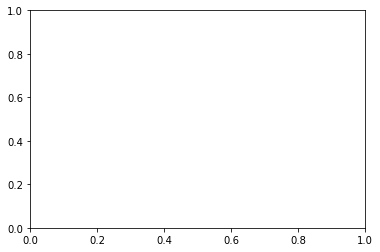

In [98]:
fig, ax = plt.subplots()

#Plot generation lines for each resource as stacked area chart.
lst = list(resource_gen_dict.values())
lines = [item[start_hour:end_hour] for item in lst]
labels = list(resource_gen_dict.keys())

if resource_charge_dict.keys():
    lst_neg = list(resource_charge_dict.values())
    lines_neg = [item[start_hour:end_hour] for item in lst_neg]
    labels_neg = list(resource_charge_dict.keys())

cmap = plt.get_cmap('tab20')
colors = cmap(np.linspace(0, 1.0, (len(lines))))
if resource_charge_dict.keys():
    colors = cmap(np.linspace(0, 1.0, (len(lines)+len(lines_neg))))

plt.stackplot(profiles.index[start_hour:end_hour], lines, labels = labels, colors = colors[0:len(lines)+1])

if resource_charge_dict.keys():
    plt.stackplot(profiles.index[start_hour:end_hour], lines_neg, labels = labels_neg, colors = colors[len(lines):])

#Plot demand.
harbor = pd.read_csv('data/harbor_hourly_gen_emissions_2019.csv')
harbor = harbor.fillna(0)
plt.plot(profiles.index[start_hour:end_hour], harbor['load_mw'][start_hour:end_hour], label = 'DEMAND', color = 'k', linewidth = 3)


sns.set()
ax.legend(loc = 'center left', bbox_to_anchor=(1,0.77), fontsize = 15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Hour', fontsize = 20)
ax.set_ylabel('Generation (MW)', fontsize = 20)
ax.set_title('Hourly Generation (MW) by Resource in Year '+ str(results_year+1),fontsize = 20).set_position([.5, 1.05])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.set_size_inches(20, 10)

#### To plot by individual resource, run the following cell to get a list of resource names. Then choose one and put it in quotations in the subsequent cell.

In [11]:
print(list(resource_gen_dict.keys()))

['gas_ct', 'ci_shed_nonwatersystem', 'utility_solar_outofbasin', 'commercial_solar', 'residential_solar', 'FCZ7.Commercial.College.Cooking', 'FCZ7.Commercial.College.DaylightingEff', 'FCZ7.Commercial.College.IndoorLightingEff', 'FCZ7.Commercial.College.OfficeEquipment', 'FCZ7.Commercial.College.Refrigeration', 'FCZ7.Commercial.College.Ventilation', 'FCZ7.Commercial.Food.Cooking', 'FCZ7.Commercial.Food.Cooling', 'FCZ7.Commercial.Food.DaylightingEff', 'FCZ7.Commercial.Food.IndoorLightingEff', 'FCZ7.Commercial.Food.OfficeEquipment', 'FCZ7.Commercial.Food.Refrigeration', 'FCZ7.Commercial.Food.Ventilation', 'FCZ7.Commercial.Health Care.Cooking', 'FCZ7.Commercial.Health Care.DaylightingEff', 'FCZ7.Commercial.Health Care.IndoorLightingEff', 'FCZ7.Commercial.Health Care.OfficeEquipment', 'FCZ7.Commercial.Health Care.Refrigeration', 'FCZ7.Commercial.Health Care.Ventilation', 'FCZ7.Commercial.Hotel.Cooking', 'FCZ7.Commercial.Hotel.DaylightingEff', 'FCZ7.Commercial.Hotel.IndoorLightingEff', 'FCZ7

In [12]:
#Change resource name in quotations 
selected_resource = 'gas_ct'

#### Choose a build year, start hour, and end hour to display results.

In [13]:
#Choose a build year to display results, index starts at 0.
results_year = 0

#Choose the hour range to display results, index starts at 0.
start_hour = 0
end_hour = 8760

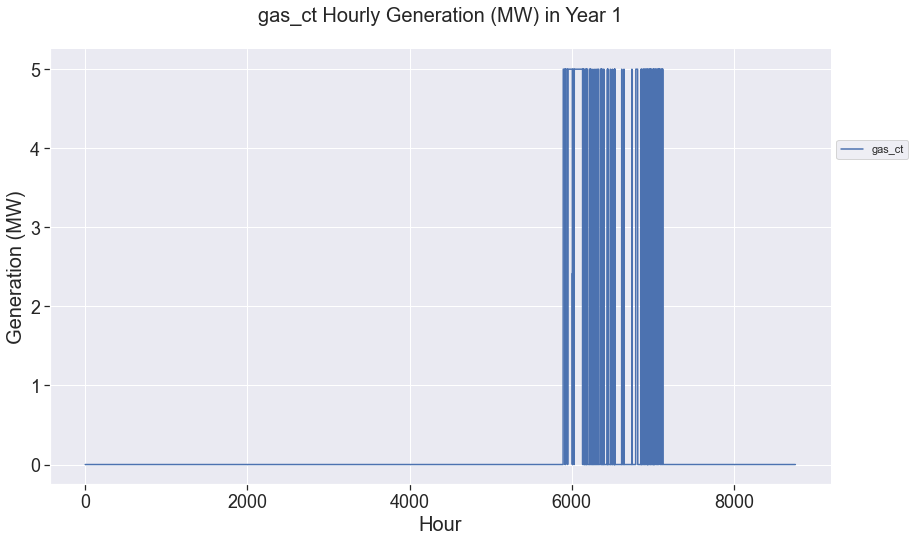

In [14]:
fig, ax = plt.subplots()

if selected_resource in list(resource_gen_dict.keys()):
    gen_line = resource_gen_dict[selected_resource]
    plt.plot(profiles.index[start_hour:end_hour], gen_line[start_hour:end_hour], label = str(selected_resource)) 

if selected_resource in list(resource_charge_dict.keys()):
    gen_line = resource_charge_dict[selected_resource]
    plt.plot(profiles.index[start_hour:end_hour], gen_line[start_hour:end_hour], label = str(selected_resource)) 
    
#Plot demand.
#plt.plot(profiles.index[start_hour:end_hour], profiles.DEMAND[start_hour:end_hour], label = 'DEMAND', color = 'k')


sns.set()
ax.legend(loc = 'center left', bbox_to_anchor=(1,0.77))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Hour', fontsize = 20)
ax.set_ylabel('Generation (MW)', fontsize = 20)
ax.set_title(selected_resource +' Hourly Generation (MW) in Year '+ str(results_year+1),fontsize = 20).set_position([.5, 1.05])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
fig.set_size_inches(14, 8)

#### To sweep through values of a particular parameter, follow the format below. Set the chosen parameter equal to the 'parameter_value' when running the linear program. Then run the cell and wait for the solver to find the optimal solution for each parameter value.

In [28]:
runs = {}

#Change the values in parentheses to starting value, ending value, interval between runs.
for parameter_value in np.arange(0, 1500, 500):
    print(parameter_value)
    
    #Set the chosen parameter equal to 'parameter_value'
    lp = harboropt_lp_storage_buildyear_emissions.LinearProgram(storage_resilience_incentive_per_kwh = parameter_value)
    lp.solve()
    runs[parameter_value] = lp 

0
Solver found optimal solution.
500
Solver found optimal solution.
1000
Solver found optimal solution.


#### Follow the format below to plot the results. In the following example, resilient storage capacity is plotted as a function of the resilient storage incentive.

In [29]:
#Create list of the parameter values looped through above. This will become the x-axis in the figure below.
parameter_values = []

#Create list to hold output values for the dependent variable. This will beomce the y-axis in the figure below.
y_values = []

#Loop through the optimization results, adding the x-values and y-values to the lists above.
for key in runs:
    parameter_values.append(key)
    
    #In this case, the y-value is the storage capacity solution value in the chosen results year. For non-storage resource capacity solution values, use "runs[key].capacity_vars" instead of "runs[key].storage_capacity_vars"
    y_value = runs[key].storage_capacity_vars['resilient_standalone_storage_4hr'][results_year].solution_value()
    y_values.append(y_value)

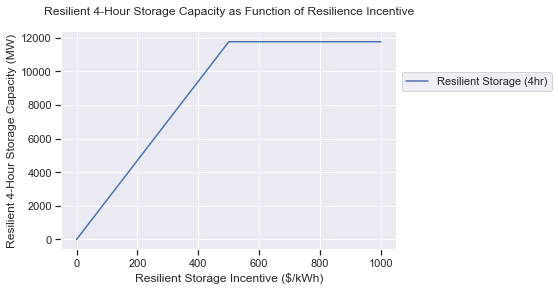

In [30]:
#Change labels to reflect variables graphed.

fig, ax = plt.subplots()

plt.plot(parameter_values, y_values, label = 'Resilient Storage (4hr)') 

sns.set()
ax.legend(loc = 'center left', bbox_to_anchor=(1,0.77))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Resilient Storage Incentive ($/kWh)')
ax.set_ylabel('Resilient 4-Hour Storage Capacity (MW)')
ax.set_title('Resilient 4-Hour Storage Capacity as Function of Resilience Incentive').set_position([.5, 1.05])

In [84]:
profiles = pd.read_csv('data/gen_profiles.csv')

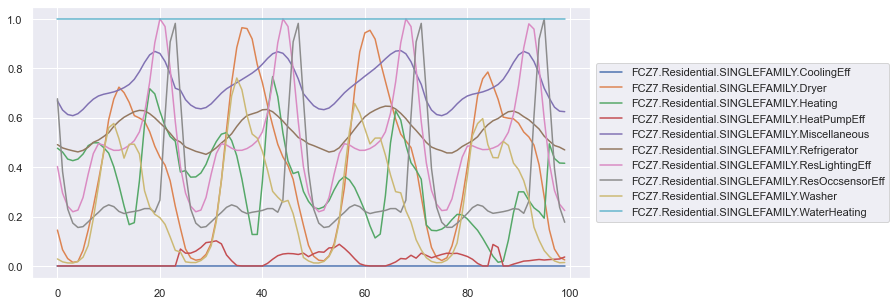

In [87]:
enduse = 'SINGLEFAMILY'
enduse_cols = [col for col in profiles.columns if enduse in col]
profiles = profiles[:100][enduse_cols]

profiles.plot.line(figsize=(10,5))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


In [ ]:
lcoe_per_mwh_by_resource = {}
        
for resource in self.capacity_vars:

    lcoe_per_mwh_by_resource[resource]={}

    for build_year in range(self.build_years):

        resource_inds = self.resource_costs['resource']==resource
        cost_year = self.build_start_year + build_year

        capex = self.lcoe_dict[build_year][resource]['capex']
        fixed_extrapolated = self.lcoe_dict[build_year][resource]['fixed_extrapolated']

        #Get range of hours where demand is met in order to index correctly into the list of generation variables.
        demand_year = self.build_years-1
        demand_start_hour = (self.build_years-1)*8760
        demand_end_hour = (self.build_years-1)*8760 + 8760

        #For dispatchable resources, calculate extrapolated variable cost and annual generation per mw of capacity.
        if resource in self.disp.index:

            #Calculated extrapolated variable cost and add to lcoe dictionary. Excludes health impacts of monetized emissions.
            if 'gas' in resource:
                variable_om_inds = self.resource_costs['cost_type']=='variable_per_mwh'
                variable_fuel_cost_inds = self.resource_costs['cost_type']=='fuel_costs_per_mmbtu'
                heat_rate_inds = self.resource_costs['cost_type']=='heat_rate_mmbtu_per_mwh'

                variable_om_cost = self.resource_costs.loc[variable_om_inds & resource_inds,str(cost_year)].item() 
                variable_fuel_cost = self.resource_costs.loc[variable_fuel_cost_inds & resource_inds, str(cost_year)].item()
                variable_heat_rate = self.resource_costs.loc[heat_rate_inds & resource_inds, str(cost_year)].item()

                variable_cost = variable_om_cost + (variable_fuel_cost*variable_heat_rate)# + resource_monetized_emissions

            else:
                variable_cost_inds = self.resource_costs['cost_type']=='variable_per_mwh'
                variable_cost = self.resource_costs.loc[variable_cost_inds & resource_inds,str(cost_year)].item()#+ resource_monetized_emissions

            variable_cost_extrapolated = variable_cost * self.discounting_factor[build_year]

            self.lcoe_dict[build_year][resource]['variable_extrapolated'] = variable_cost_extrapolated

            summed_gen = 0
            #Currently sums generation in the year in which demand must be met with supply (the last build year).
            for i_gen in self.disp_gen[str(resource)][demand_start_hour:demand_end_hour]:
                summed_gen += i_gen.solution_value()

            capacity_cumulative = self.capacity_vars[resource][0:self.build_years+1]
            capacity_total = 0
            for i, var in enumerate(capacity_cumulative):
                capacity_total += var.solution_value()

            if capacity_total >0:
                mwh_per_mw = summed_gen / capacity_total
                self.lcoe_dict[build_year][resource]['annual_generation_per_mw'] = mwh_per_mw
            else:
                print(resource,': Resource is not selected in optimization solution. Cannot calculate LCOE because annual generation is N/A.')

        elif resource in self.nondisp.index:

            profile_max = max(profiles[resource])
            summed_gen = sum(profiles[resource] / profile_max)

            #Add variable costs extrapolated over portfolio timespan to lcoe dictionary.
            self.lcoe_dict[year][resource]['variable_extrapolated']=self.resource_costs.loc[variable_cost_inds & resource_inds, str(cost_year)].item() * summed_gen * self.discounting_factor[build_year]

            #Add annual mwh generated per mw capacity to lcoe dictionary.
            self.lcoe_dict[year][resource]['annual_generation_per_mw']=summed_gen

            variable_cost_extrapolated = self.lcoe_dict[build_year][resource]['variable_extrapolated']
            mwh_per_mw = self.lcoe_dict[build_year][resource]['annual_generation_per_mw']


        variable_costs = variable_cost_extrapolated * mwh_per_mw
        lcoe_per_mw = capex + fixed_extrapolated + variable_costs
        lcoe_per_mwh = lcoe_per_mw / (mwh_per_mw*self.timespan)

        lcoe_per_mwh_by_resource[resource][build_year] = lcoe_per_mwh
        